<h2>Dogecoin, prediciendo su precio de mercado<h2>

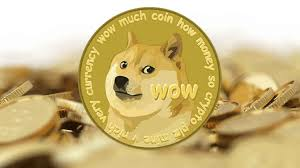

El presente trabajo tiene por objetivo visualizar la performance de dos modelos distintos en la predicción de valores en una serie de tiempo: **XGBOOST** & **LSTM**.

Realizaremos tanto el proceso de obtención de datos como la limpieza de ellos, para luego aplicar los dos modelos y llegar a una conclusión sobre cuál de ellos es mejor.

Sobre la criptomoneda, es el DOGECOIN, popularizado recientemente en Internet mediante el fenomeno de WSB y los tweets de Elon Musk que tienen como consencuencia una gran turbulencia en su precio.

El presente trabajo tiene labor meramente educativa en la aplicación de librerias de ML en Ipython

<h3>Librerias</h3>

---






In [99]:
import requests
import json
import pandas as pd
from sklearn import preprocessing
import statsmodels.api as smt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

<h3>Caracteristicas de la data</h3>

---



El siguiente enlace permite acceder al valor del Dogecoin en USD por medio de un requests a Yahoo Finance, obteniendo los valores en intervalos de 2 minutos. 


In [122]:
data = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/DOGE-USD?region=US&lang=en-US&includePrePost=false&interval=2m&useYfid=true&range=60d&corsDomain=finance.yahoo.com&.tsrc=finance')
data_final = data.json()

El request entrega los valores del Dogecoin cada 2 minutos, junto con información propia de la criptomoneda, como:
- Volumen (**volume**): Volumen de transacciones
- Valor de apertura (**open**): Valor de la moneda al inicio de cada intervalo
- Valor de cierre (**close**): Valor de la criptomoneda al cierre de cada intervalo
- Valor máximo (**high**): Valor máximo de la criptomoneda en cada intervalo
- Valor minimo (**low**): Valor minimo de la criptomoneda en cada intervalo


In [123]:
data_final['chart']['result'][0]['indicators']['quote'][0].keys()

dict_keys(['volume', 'high', 'open', 'low', 'close'])

Dado que la información proviene de un requests, es imperante verificar que el número de elementos de cada uno de los campos anteriores coincida, esto permitira asegurar la construcción de un Dataframe

In [124]:
len(data_final['chart']['result'][0]['indicators']['quote'][0]['low']) == len(data_final['chart']['result'][0]['indicators']['quote'][0]['volume']) == len(data_final['chart']['result'][0]['indicators']['quote'][0]['close']) ==len(data_final['chart']['result'][0]['indicators']['quote'][0]['high'])==len(data_final['chart']['result'][0]['indicators']['quote'][0]['open'])

True

En base a los datos anteriores, construiremos el Dataframe

In [125]:
df = pd.DataFrame(columns=['low', 'volume', 'close', 'high', 'open'])
df['low'] = data_final['chart']['result'][0]['indicators']['quote'][0]['low']
df['volume'] = data_final['chart']['result'][0]['indicators']['quote'][0]['volume']
df['close'] = data_final['chart']['result'][0]['indicators']['quote'][0]['close']
df['high'] = data_final['chart']['result'][0]['indicators']['quote'][0]['high']
df['open'] = data_final['chart']['result'][0]['indicators']['quote'][0]['open']

In [126]:
df

,low,volume,close,high,open
0,0.008154,0.0,0.008154,0.008154,0.008154
1,0.008150,0.0,0.008151,0.008151,0.008150
2,0.008118,0.0,0.008118,0.008121,0.008121
3,0.008099,807472.0,0.008099,0.008123,0.008123
4,0.008096,34400.0,0.008096,0.008098,0.008098
...,...,...,...,...,...
25345,0.050784,1379072.0,0.050784,0.050822,0.050822
25346,0.050606,1805568.0,0.050606,0.050624,0.050624
25347,0.050585,794112.0,0.050585,0.050612,0.050612
25348,0.050583,0.0,0.050583,0.050583,0.050583


<h3>Pre-procesamiento de la información</h3>

---





Dado que la información proviene de un requests, es necesario eliminar todas aquellas filas que contengan NaN

In [127]:
df.dropna(inplace=True)

Observemos ahora como se ve la información a lo largo del tiempo, mediante el ploteo de los valores tanto de **open**, **close**, **low**, **volume** & **high**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f10c101a490>,
      dtype=object)

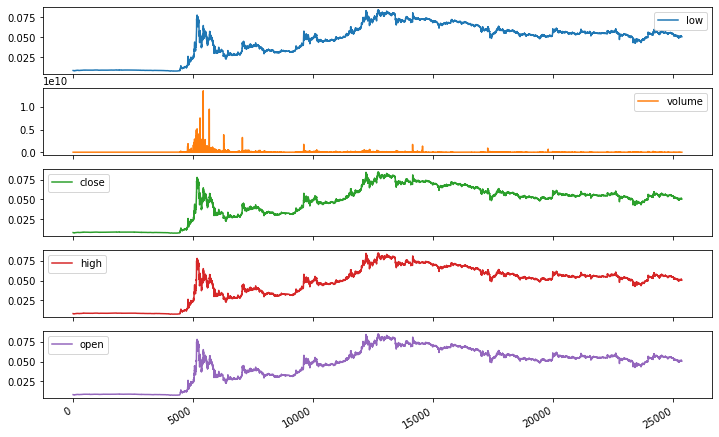

In [128]:
df.plot(subplots=True, figsize=(12,8))

Debemos normalizar la información, para ello aplicaremos MinMaxScaler, además transformaremos la información a un array por medio del método **.to_numpy**.
Normalizar la información es totalmente necesario en el analisis estadistico, dado que con ello eliminamos las unidades de medida de un dataset, permitiendo comparar distintos valores que inicialmente estaban en diferentes escalas.

In [129]:
pr = preprocessing.MinMaxScaler()
df_normalized = pr.fit_transform(df)
data_data = df.to_numpy()

In [130]:
df_normalized_final = pd.DataFrame(df_normalized, columns=df.columns)

Ahora definiremos la función plotcharts, esta función nos ayudara con el concepto de la Autocorrelación Parcial, esto nos ayuda a ver que tan correlacionados estan  los valores $(y_t, y_{t-k})$, dado un valor t y k pasos anteriores a este. En este caso veremos como es la Autocorrelación **50** pasos anteriores.


In [131]:
def plotcharts(y, title, lags=None, figsize=(12,8)):
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight="bold")
    y.plot(ax=hist_ax, kind="hist", bins=25)
    hist_ax.set_title("Histogram")
    smt.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

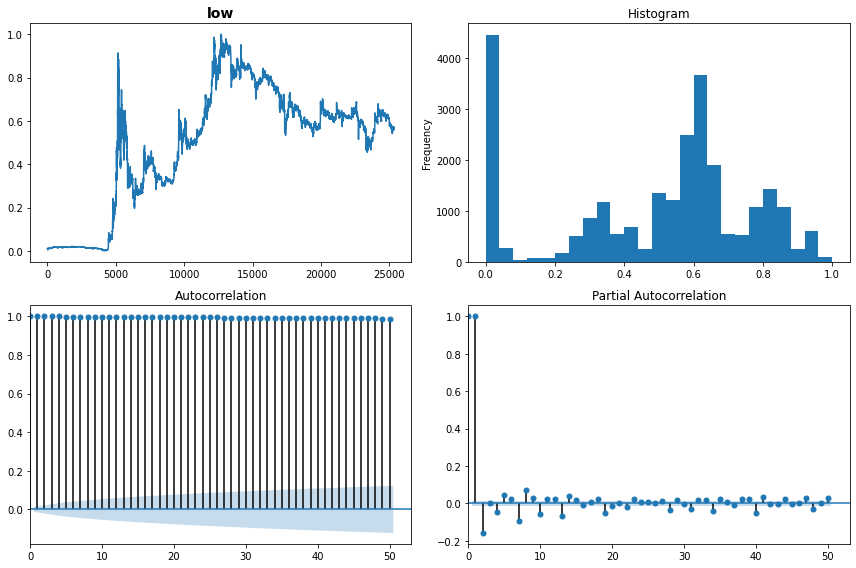

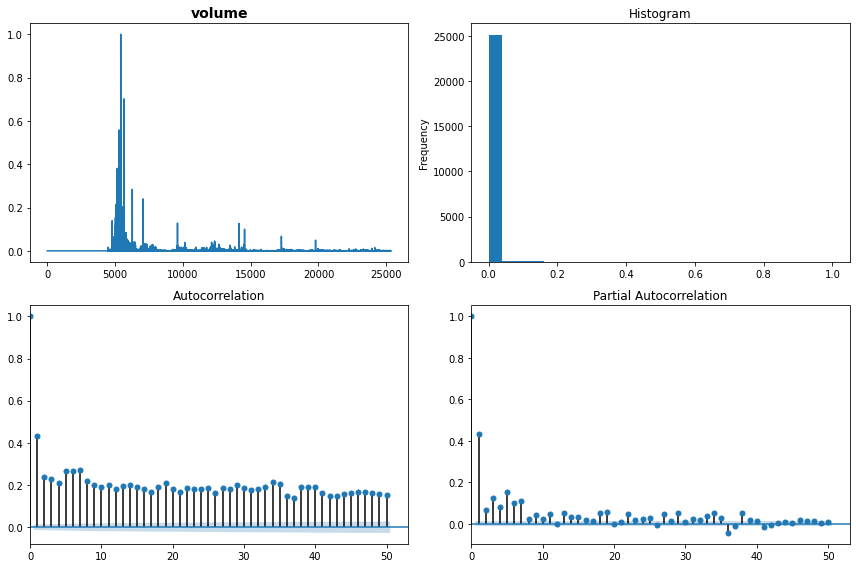

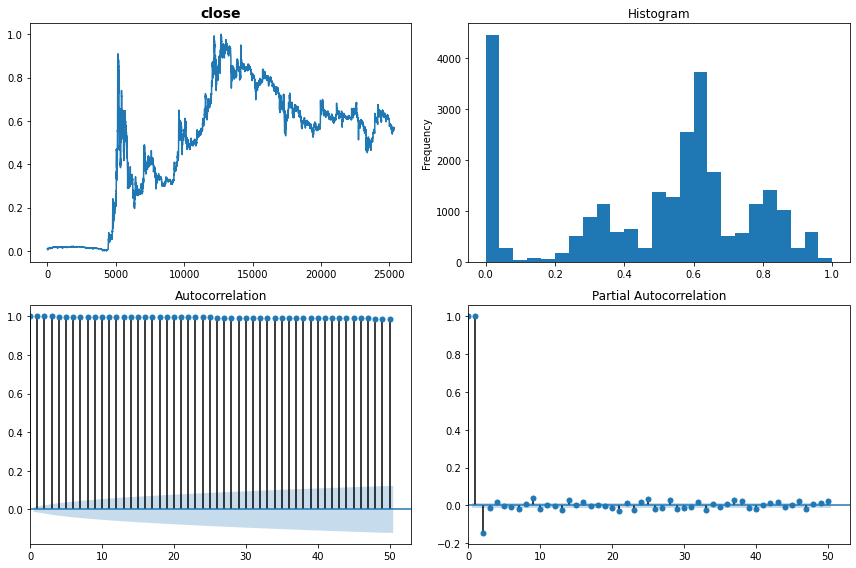

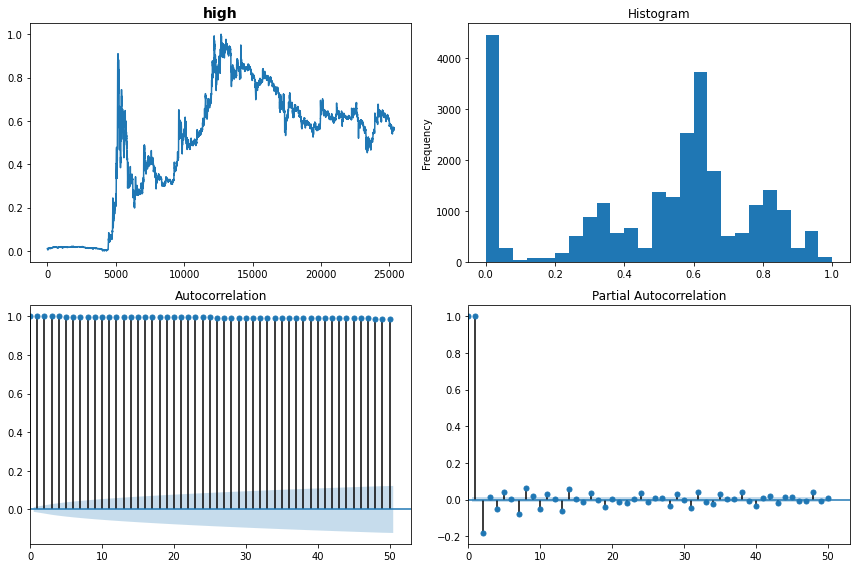

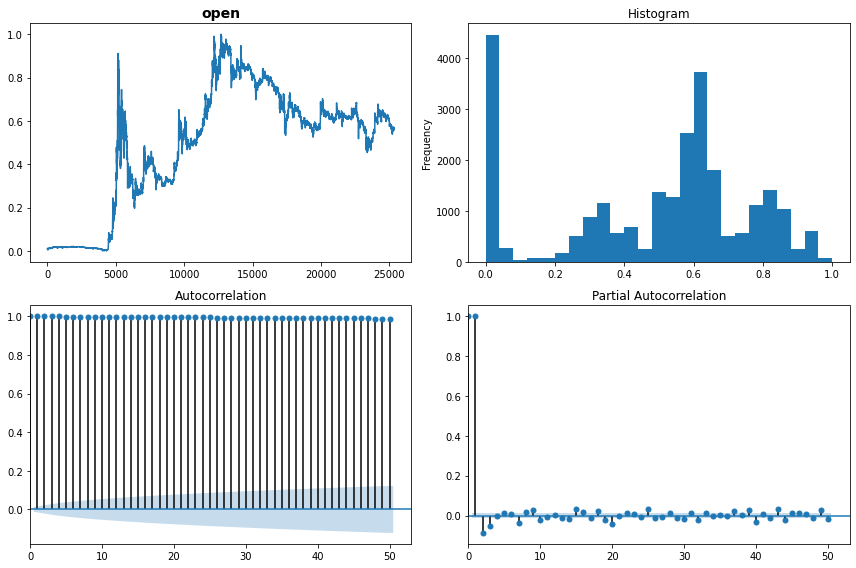

In [132]:
series = df_normalized_final
num_var = len(series.iloc[1,:])
for i in range(0, num_var):
    plotcharts(series.iloc[:,i].dropna(), title=series.columns[i], lags=50)

In [133]:
n_obs = int(len(df_normalized_final)*0.1)
train, test = df_normalized_final[:-n_obs], df_normalized_final[-n_obs:]
assert train.shape[0]+test.shape[0] == len(df_normalized_final)

<h3>XGBOOST</h3>

---

---





Usaremos en primera parte modelos XGBoost para lograr predecir el valor.

In [134]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X, y = df_normalized_final.iloc[:,:], df_normalized_final.iloc[:,0]

In [135]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Definiremos el regresor linear de **xgb** y en base a la separación de la data en conjunto de training y el de testing, buscaremos ver el poder de predicción del modelo, usaremos como indicador de error el *error cuadratico medio*, dado que es un buen indicador en la aproximación de funciones.

In [136]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 1, alpha = 10, n_estimators = 200)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[04:59:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Observamos que el error cuadratico medio es de 0,0081, el cual se puede considerar bajo, por lo que se podría afirmar que el modelo **xgb** tiene un gran poder predictivo.

In [143]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.008177


<h4>CrossVal para el calculo del Error Cuadrático Medio</h4>

Realizaremos un cross validation para verificar en el conjunto de entrenamiento y en el de testeo el valor del error cuadrático medio.

In [144]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 2, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=500,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[05:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [145]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.252110,0.000582,0.252106,0.001180
1,0.228270,0.000528,0.228262,0.001113
2,0.207060,0.000381,0.207061,0.001160
3,0.187874,0.000465,0.187852,0.000977
4,0.170509,0.000387,0.170479,0.000975


In [146]:
print((cv_results["test-rmse-mean"]).tail(1))

499    0.007642
Name: test-rmse-mean, dtype: float64


Podemos observar que a medida que se avanza en el número de iteraciones, el valor del RMSE va bajando, de ahí que en el paso 500 el valor del RSME es de 0.007642, el cual se puede considerar el más bajo posible de calcular.

En los gráficos siguientes, se observa la evolución visual de los distintos RMSE a lo largo de cada iteración.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f10de979c90>,
      dtype=object)

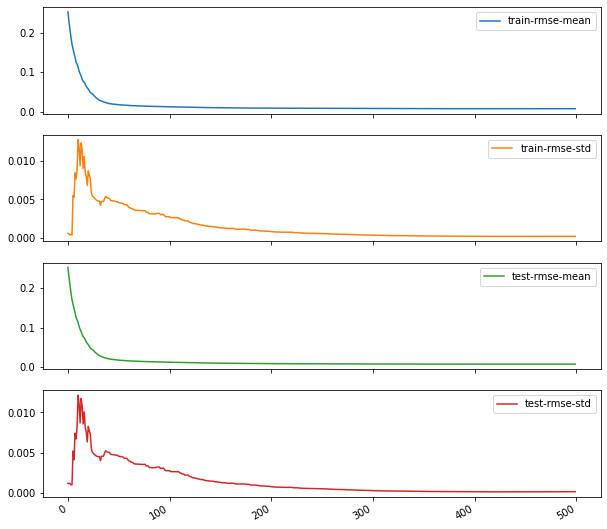

In [147]:
cv_results.plot(subplots=True, figsize=(10,10))

<h3>Normalización y definición de conjuntos</h3>

---

---





Ahora viene la parte entretenida, definiremos diversos objetos que nos permitiran realizar la labor **predictiva**, como también definiremos los valores que son considerados como **esperados**.
- ohlcv_histories_normalised: Corresponde a los valores **X** que orientaran la predicción, el intervalo [i : i + 50] contiene cincuenta valores dentro del array,  esto permitira crear la predicción con el foco de que a partir de los **cincuenta** valores previos logremos predecir el valor **cincuenta y uno**.
- next_day_open_values_normalised: Contiene los valores asociados a la columna **low** [:,0] desde el valor **50** en adelante, estos son los valores  **Y**.
- next_day_open_values: Busca el mismo proposito que next_day_open_values_normalised, solo que esta data no esta normalizada

In [148]:
ohlcv_histories_normalised = np.array([df_normalized[i  : i + 50].copy() for i in range(len(df_normalized) - 50)])
next_day_open_values_normalised = np.array([df_normalized[:,0][i + 50].copy() for i in range(len(df_normalized) - 50)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
next_day_open_values = np.array([data_data[:,0][i + 50].copy() for i in range(len(data_data) - 50)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)


Normalizaremos next_day_open_values usando MinMaxScaler

In [149]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

MinMaxScaler(copy=True, feature_range=(0, 1))

Separaremos la información en los conjuntos de entrenamiento y testeo, donde asignaremos el 90% a entrenamiento y el restante 10% para testeo.

In [150]:
test_split = 0.9 
n = int(ohlcv_histories_normalised.shape[0] * test_split)

ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]

unscaled_y_test = next_day_open_values[n:]

<h3>LSTM</h3>

---

---





Aplicaremos una LSTM para predecir el valor del DOGECOIN a futuro, para eso definimos 50 celdas en la red LSTM (esto se relaciona con los 50 valores previos en la predicción de un valor), definiremos un Dropout de 0.2 y una función sigmoidea como función de activación.

En la siguiente imagen observamos el esquema de sucesión de funciones de la red LSTM

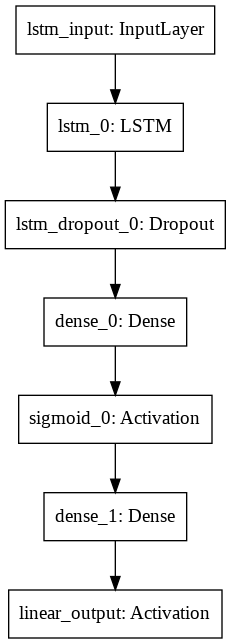

In [151]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

from keras import optimizers
import numpy as np
np.random.seed(4)

lstm_input = Input(shape=(50, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png')

Entrenaremos la LSTM con 50 epochs, con los valores de X = ohlcv_train (que corresponde al 90% previo de ohlcv_histories_normalised) e Y = y_train (que corresponde al 90% previo de next_day_open_values_normalised).

El hecho de hablar del 90% previo hace referencia al 9/10 partes del conjunto visto como un conjunto ordenado asociado a una serie de tiempo.

In [152]:
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)

Epoch 1/50
641/641 [==============================] - 11s 5ms/step - loss: 0.0779 - val_loss: 4.9514e-05
Epoch 2/50
641/641 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 7.1298e-05
Epoch 3/50
641/641 [==============================] - 3s 4ms/step - loss: 8.0474e-04 - val_loss: 1.1333e-04
Epoch 4/50
641/641 [==============================] - 3s 4ms/step - loss: 7.6890e-04 - val_loss: 1.4662e-04
Epoch 5/50
641/641 [==============================] - 3s 4ms/step - loss: 7.0498e-04 - val_loss: 2.9680e-05
Epoch 6/50
641/641 [==============================] - 3s 4ms/step - loss: 6.5723e-04 - val_loss: 2.5755e-05
Epoch 7/50
641/641 [==============================] - 3s 4ms/step - loss: 6.7479e-04 - val_loss: 2.5039e-05
Epoch 8/50
641/641 [==============================] - 3s 4ms/step - loss: 5.9181e-04 - val_loss: 2.8857e-05
Epoch 9/50
641/641 [==============================] - 3s 4ms/step - loss: 5.8218e-04 - val_loss: 2.8324e-05
Epoch 10/50
641/641 [==============

Veamos la evaluación del módelo, esto nos ayudara a dimensionar que tan alejados o cercanos estamos a la realidad

In [153]:
evaluation

1.2204597624076996e-05

Consideremos las siguientes variables que nos ayudaran a calcular el error cuadrático medio:

- y_test_predicted: Corresponde al valor predecido por la LSTM bajo normalización inversa del **10% de datos**, esto permite conocer los valores **reales** que generaria la LSTM.
- y_predicted: Corresponde al valor predecido por la LSTM bajo normalización inversa del **90% de datos**.

In [154]:
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

y_predicted = model.predict(ohlcv_histories_normalised)
y_predicted = y_normaliser.inverse_transform(y_predicted)


Verificamos que la dimensión de y_test_predicted es la misma que unscaled_y_test

In [155]:
assert unscaled_y_test.shape == y_test_predicted.shape

Calculemos el error cuadrático medio

In [156]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
scaled_mse

0.0004224426449292211

Si observamos, el error cuadrático medio es bajo, eso si buscaremos más adelante como mejorar la performance del modelo agregando otros indicadores.

Ahora observemos el ploteo de los conjuntos de test/predicted, con estos valores veremos visualmente que tan acertada es la predicción.

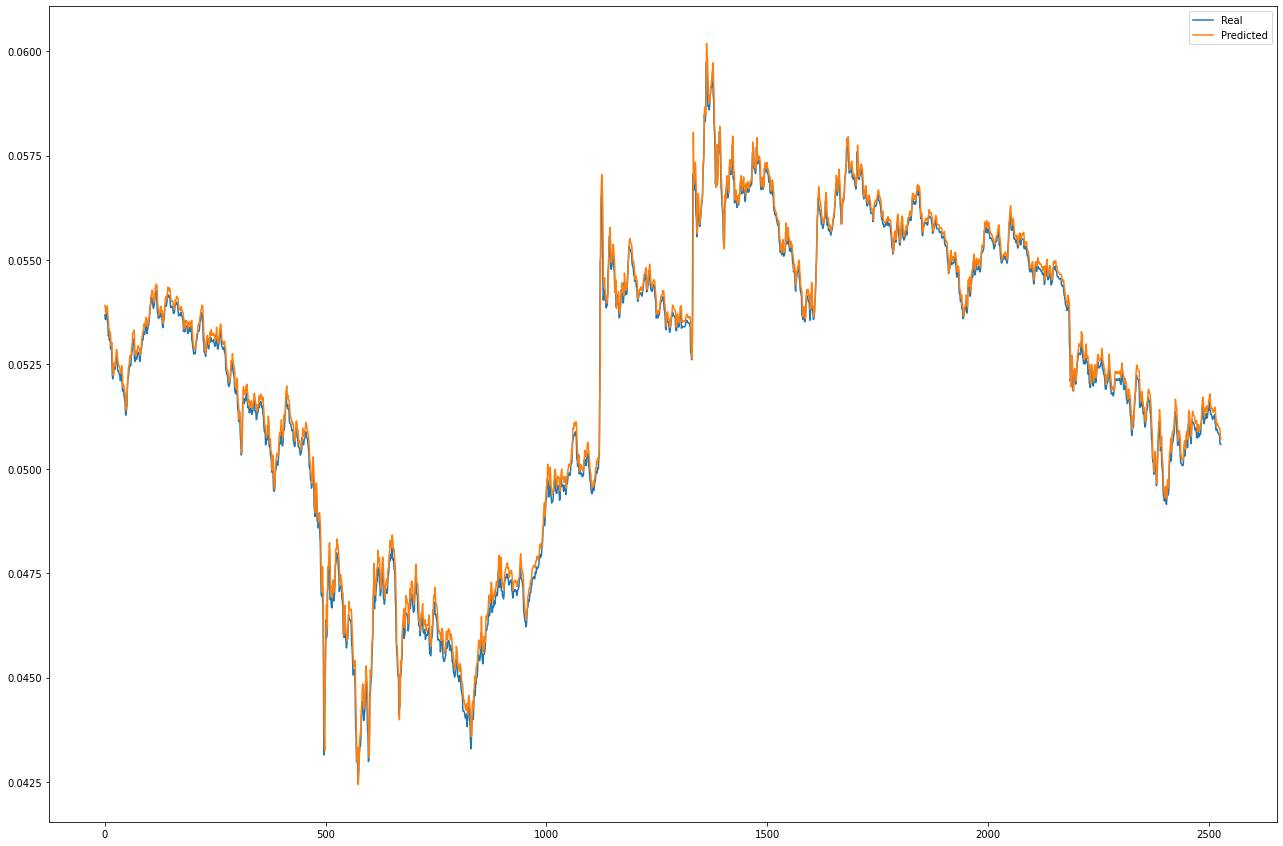

In [157]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

<h4>Posible mejora de LSTM</h4>

Ahora para mejorar la performance del modelo, usaremos un indicador llamado SMA, este indicador calcula el precio promedio de **n** pasos previos al valor que esperamos predecir, para este caso definiremos n = 50.

Para este caso usaremos his[:, 2] que corresponde a la columna de **close** del Dataframe, en base a este valor promedio nos ayudara a predecir el comportamiento del modelo en base al promedio de cierre de los 50 pasos anteriores.



In [158]:
technical_indicators = []
for his in ohlcv_histories_normalised:
    sma = np.mean(his[:,2])
    technical_indicators.append(np.array([sma]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = preprocessing.MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]

Ahora repetiremos el paso anterior, pero agregaremos las medias dentro de la red, definiremos las siguientes variables para su uso dentro de la LSTM.
- ohclv_train: Se define como el **90%** de la data X de entrenamiento
- y_train: Se define como el **90%** de la data de next_day_open_values_normalized, vale decir, es la data desde el dato *post 50* en adelante.
Para **ohlcv_test** e **y_test** cumple la misma función anterior
- tech_ind_train: Corresponde al 90% de los datos de medias de 50 datos.
- tech_ind_test: Corresponde al 10% de los datos de medias de 50 datos.

In [159]:
test_split = 0.9 
n = int(ohlcv_histories_normalised.shape[0] * test_split)

ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]

unscaled_y_test = next_day_open_values[n:]

tech_ind_train = technical_indicators_normalised[:n]
tech_ind_test = technical_indicators_normalised[n:]

Ahora desarrollaremos la red LSTM, para ello definiremos dos grandes ramas que serán las que nos ayudaran a predecir, por un lado ira la data anterior sumado a una nueva red que analizara los promedios cada 50 pasos, en base a esto veremos si el modelo tiene una mejor performance o no.

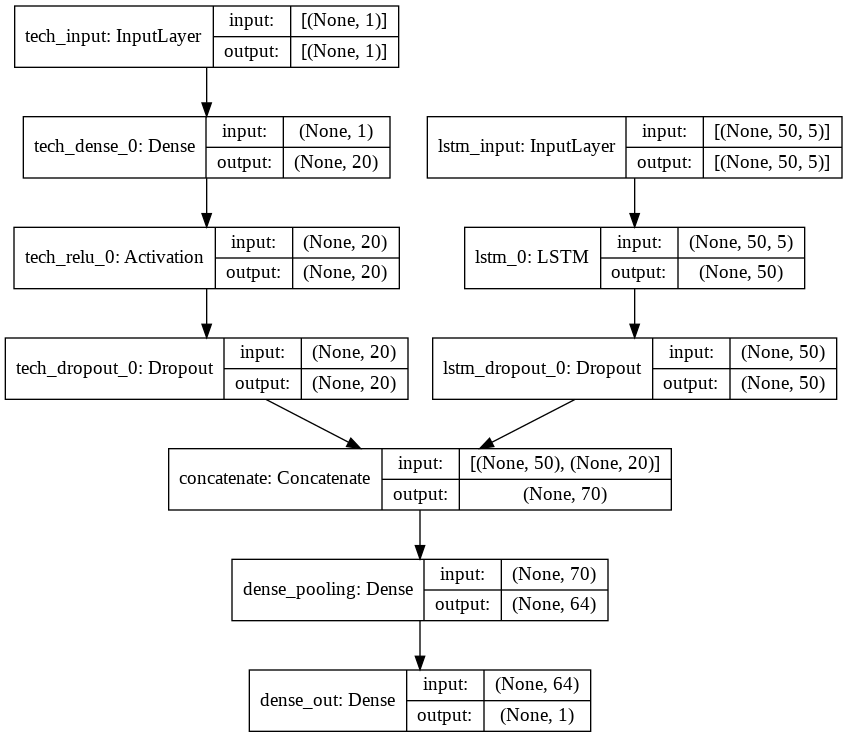

In [160]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)

lstm_input = Input(shape=(50, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [161]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)


Epoch 1/50
641/641 [==============================] - 5s 5ms/step - loss: 0.0278 - val_loss: 1.5239e-04
Epoch 2/50
641/641 [==============================] - 3s 4ms/step - loss: 8.6902e-04 - val_loss: 9.2066e-05
Epoch 3/50
641/641 [==============================] - 3s 4ms/step - loss: 7.1481e-04 - val_loss: 1.9400e-04
Epoch 4/50
641/641 [==============================] - 3s 5ms/step - loss: 6.2476e-04 - val_loss: 1.3503e-04
Epoch 5/50
641/641 [==============================] - 3s 5ms/step - loss: 6.1950e-04 - val_loss: 1.2403e-04
Epoch 6/50
641/641 [==============================] - 3s 5ms/step - loss: 6.1587e-04 - val_loss: 1.1823e-04
Epoch 7/50
641/641 [==============================] - 3s 5ms/step - loss: 5.8483e-04 - val_loss: 2.0851e-05
Epoch 8/50
641/641 [==============================] - 3s 5ms/step - loss: 5.5141e-04 - val_loss: 1.0927e-04
Epoch 9/50
641/641 [==============================] - 3s 4ms/step - loss: 5.7560e-04 - val_loss: 8.1553e-05
Epoch 10/50
641/641 [===========

In [162]:
evaluation

1.1905022802238818e-05

In [163]:
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)


Calculemos el error cuadrático medio de la segunda propuesta de LSTM usando la media móvil de 50 valores

In [164]:
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
scaled_mse

0.00041207358861055233

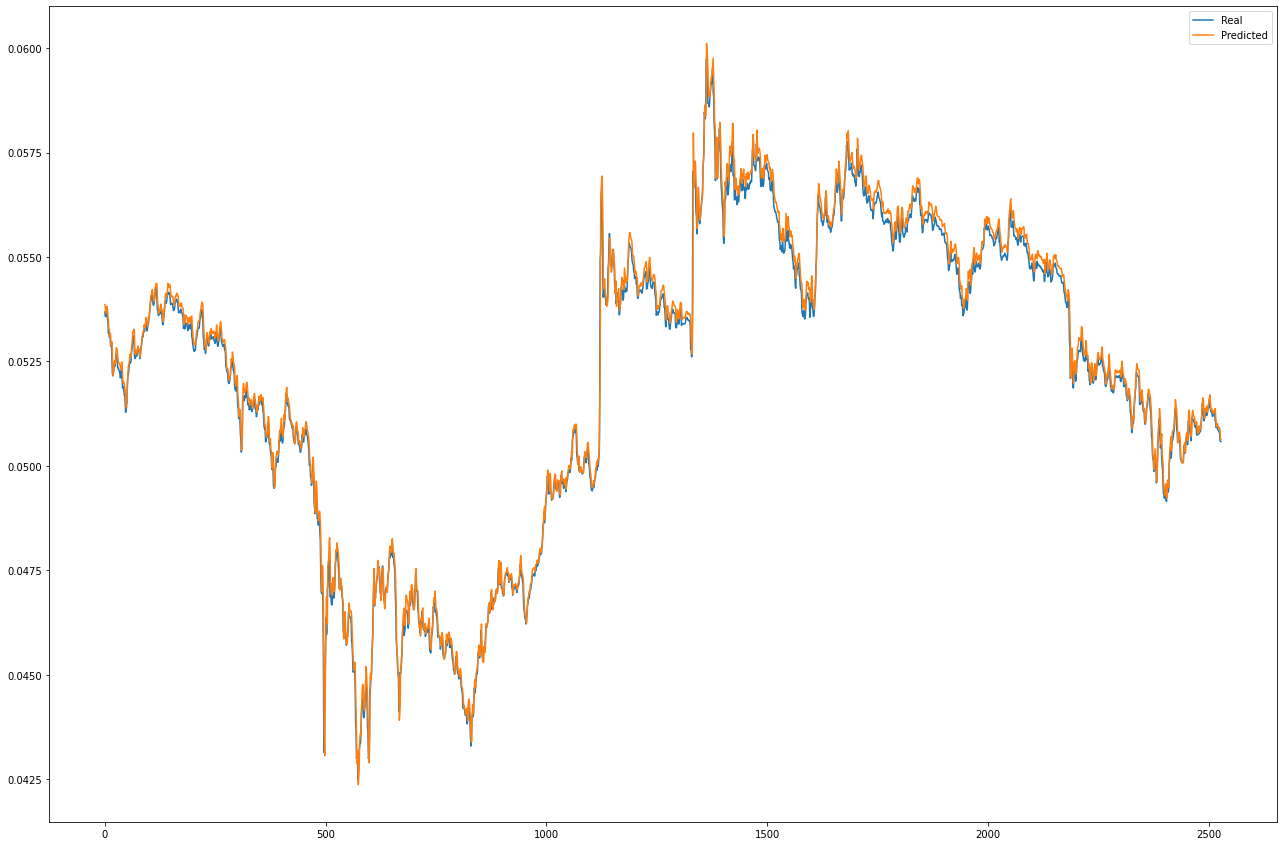

In [165]:

import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

<h3>Conclusión</h3>

---

---








Es posible observar que la predicción de la red LSTM es mejor (en 1 orden de magnitud) al XGBOOST, lo que iria de la mano con la mejor capacidad que tiene la LSTM de recibir distintos tipos de información multidimiensional como input, el hecho que pueda recibir arrays de cincuenta valores como input es una gran ventaja.

Tambien se observo que el hecho de añadir la media (50) móvil a la red LSTM, mejoro en un 0.0001 aprox. la performance del modelo - medido en MSE - eso si, cabe mencionar que esta condición no se cumple siempre en el tiempo, quizas para el lector al momento de ejecutar este código no se cumpla una mejora al añadir este valor, eso quizas se debe a las perturbaciones que sufre el valor producto de la influencia de distintos actores, quienes quizás sin querer, terminan manipulando el valor de la criptomoneda.